# Preparing the dataset
Objective: Try a second approach for the images that didn't work. 

In [18]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os 

imgs_path_train = '/home/a52550/Desktop/datasets/ISIC2017/train/'

def save_image(name, img):
    path =  '{}segmented_images/{}.jpg'.format(imgs_path_train,name)
    cv.imwrite(path, img)
    print('saved image: {}'.format(path))

# def save_in_test(name, img):
#     cv.imwrite('..\datasets\ISIC2017\Training_data_processed_2\\tests\\{}.jpg'.format(name), img)

def read_image(name):
    path = '{}ISIC-2017_Training_Data/{}.jpg'.format(imgs_path_train,name)
    img = cv.imread(path)

    return img



Obtaining all images name

In [19]:
all_files = os.listdir(imgs_path_train+'ISIC-2017_Training_Data/')
all_images = []
for file in all_files:
        if file.find('superpixels') == -1 and file.find('Training_Data_metadata') == -1 and file.find('_final') == -1 and file.find('cut_coords') == -1:
                new_img = file.split('.')[0]
                all_images.append(new_img)


Use morphological operations to better binarize the image

In [20]:
def morphological_operations(img):
    kernel = np.ones((10,10),np.uint8)
    img = cv.dilate(img,kernel,iterations = 2) 
    img = cv.erode(img,kernel,iterations = 2) 
    return img

In [21]:
# img_original = read_image('ISIC_0014395')
# img = morphological_operations(img_original)
# save_in_test('ISIC_0014395', img_original)
# save_in_test('ISIC_0014395_test', img)


Obtain the threshold image for gray scale image and blue channel

In [22]:
def threshold_image (img):
    img = cv.GaussianBlur(img,(5,5),0)
    _,img = cv.threshold(img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = np.ones((10,10),np.uint8)
    img = cv.erode(img,kernel,iterations = 1) 
    return img

Obtain the threshold image to highlight the black corners

In [23]:
def highlight_black_corners (img):
    img = cv.GaussianBlur(img,(5,5),0)
    y, x = img.shape
    for i in range(5):
        img[i,:] = 0
        img[:,i] = 0
        img[:,x-i-1] = 0
        img[y-i-1,:] = 0
    _,img = cv.threshold(img,15,255,cv.THRESH_BINARY)
    return img

Remove black corners remaining from the lens of the camera used to take the lesion image 

In [24]:
def remove_corners(img):
    y, x = img.shape

    corners = {
        'top_left': {
            'x': [0,10],
            'y': [0,10]
        },
        'top_right': {
            'x': [0,10],
            'y': [y - 11, y-1]
        },
        'bottom_left': {
            'x': [x - 11, x-1],
            'y': [0,10]
        },
        'bottom_right': {
            'x': [x - 11, x-1],
            'y': [y - 11, y-1]
        },
    }

    for position in corners:
        for x in range(corners[position]['x'][0], corners[position]['x'][1]):
            for y in range(corners[position]['y'][0], corners[position]['y'][1]):
                if img[y,x] >= 255:
                    cv.floodFill(img, None, (x,y), 0)
    return img

Add gray and blue images

In [25]:
def add_gray_and_blue(img_1, img_2):
    img_sum = img_1 + img_2
    img_sum[img_sum > 125] = 255
    img_sum[img_sum < 125] = 0
    return img_sum
    

Remove minimal blobs from the image

In [26]:
def remove_minimal_blobs(img):

    kernel = np.ones((10,10),np.uint8)
    img_clean = cv.erode(img,kernel,iterations = 2)

    contours, _ = cv.findContours(img_clean, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    img_clean = np.zeros_like(img)
    for contour in contours:
        area = cv.contourArea(contour)
        if area > 8000:
            cv.fillPoly(img_clean, [contour], 255)


    return img_clean

Get coordinates of rectangle around ROI

In [27]:
from math import floor


def get_coordinates(img, gap, square = True):
    contours, _ = cv.findContours(img,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)

    if len(contours) == 0:
        return []

    y, x = img.shape
    coords = []
    
    b,t, r, l = [y, 0, -1, 9999999]
    
    for points in contours:
        for p in points:
            # if t > p[0][1]:
            #     t = p[0][1]
            # if b < p[0][1]:
            #     b = p[0][1]
            if l > p[0][0]:
                l = p[0][0]
            if r < p[0][0]:
                r = p[0][0]

    if square:
        if b-t > r-l:
            l -= floor(((b-t) - (r-l))/2)
            r += floor(((b-t) - (r-l))/2) - l if l < 0 else floor(((b-t) - (r-l))/2)
        # elif r-l > b-t:
        #     t -= floor(((r-l) - (b-t))/2)
        #     b += floor(((r-l) - (b-t))/2) - t if t < 0 else floor(((r-l) - (b-t))/2)

    # b = b + gap if b + gap < y else y
    # t = t - gap if t - gap > -1 else 0
    r = r if r < x else x
    l = l if l > -1 else 0

    return [b,t,r,l]

Draw rectangle based on found coordinates

In [28]:
def draw_rectangle(img, coords):

    [b,t,r,l] = coords
                
    img_final = cv.rectangle(img, (l,t), (r,b), (255, 0, 0), 3)

    return img_final

Crop in coordinates     

In [29]:
def crop_image(img, coords):
    if len(coords) != 4:
        return img
    
    [b,t,r,l] = coords
    crop = img[t:b, l:r, :]

    return crop

Get maximized coordinates

In [30]:
def get_max_coords(max_coords, coords):
    if len(coords) != 4:
        return max_coords

    [b_m,t_m,r_m,l_m] = max_coords
    [b,t,r,l] = coords

    t_m = t if t_m > t else t_m
    b_m = b if b_m < b else b_m
    r_m = r if r_m < r else r_m
    l_m = l if l_m > l else l_m

    return [b_m,t_m,r_m,l_m]

In [31]:
def remove_color(img, color):
    # Convertendo para o espaço de cores HSV
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Definindo o intervalo de matiz para excluir o azul
    if(color == 'blue'):
        low_color = np.array([90, 200, 200])
        high_color = np.array([130, 255, 255])
    elif(color == 'red'):
        low_color = np.array([0, 200, 200])
        high_color = np.array([10, 255, 255])
    elif(color == 'green'):
        low_color = np.array([35, 200, 200])
        high_color = np.array([75, 255, 255])
    elif(color == 'yellow'):
        low_color = np.array([15, 200, 200])
        high_color = np.array([35, 255, 255])
    elif(color == 'orange'):
        low_color = np.array([10, 200, 200])
        high_color = np.array([20, 255, 255])
    

    # Criando uma máscara para os pixels que estão dentro do intervalo de matiz definido
    mask = cv.inRange(hsv, low_color, high_color)

    # Aplicando a máscara para a imagem original para remover a cor azul
    result = cv.bitwise_not(img, img, mask=mask)

    result[mask > 0] = [255, 255, 255]

    return result

def remove_colors(img):
    img = remove_color(img, 'blue')
    img = remove_color(img, 'red')
    img = remove_color(img, 'green')
    img = remove_color(img, 'yellow')
    img = remove_color(img, 'orange')
    return img

In [32]:
max_coords = [-1, 9999999, -1, 9999999]
img_name = ''

data = {
    'name': [],
    'coords': []
}
# all_images = ['ISIC_0000001']
try:
    for img_name in all_images:
        
        img_rgb = read_image(img_name)
        img_rgb = remove_colors(img_rgb)
        img_rgb_2 = morphological_operations(img_rgb)
        img_black_corners = highlight_black_corners(cv.cvtColor(img_rgb_2, cv.COLOR_BGR2GRAY))
        img_black_corners_no_noise = remove_minimal_blobs(img_black_corners)
        coords_1 = get_coordinates(img_black_corners_no_noise, 0, False)
        crop = crop_image(img_rgb_2, coords_1)
        img_rgb = crop_image(img_rgb, coords_1)

        img_gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
        img_blue = crop[:,:,0]

        img_thresh_gray = threshold_image(img_gray)
        img_thresh_blue = threshold_image(img_blue)

        img_gray_no_corners = remove_corners(img_thresh_gray)
        img_blue_no_corners = remove_corners(img_thresh_blue)

        img_sum = add_gray_and_blue(img_gray_no_corners, img_blue_no_corners)
        img_clean = remove_minimal_blobs(img_sum)

        coords = get_coordinates(img_clean, 100)
        
        img_final = crop_image(img_rgb, coords)
        # print(coords, img_final.shape)
        max_coords = get_max_coords(max_coords, coords)

        data['coords'].append(' '.join(map(str,coords if len(coords) > 0 else coords_1)))

        save_image(img_name, img_final)
except Exception as e: 
    print(img_name)
    print(e)

data['name'].append('max_coords')
data['coords'].append(', '.join(map(str,max_coords)))

saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0013996.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0000352.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0011119.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0000018.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0013173.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0014088.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0013685.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0000511.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0000311.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_0000276.jpg
saved image: /home/a52550/Desktop/datasets/ISIC2017/train/segmented_images/ISIC_

KeyboardInterrupt: 

[ WARN:0@3.505] global loadsave.cpp:244 findDecoder imread_('/home/a52550/Desktop/datasets/ISIC2017/train/ISIC_0009758.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


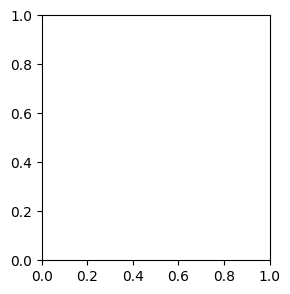

In [ ]:
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt

csv_path_train = '/home/a52550/Desktop/datasets/ISIC2017/train/ISIC-2017_Training_Part3_GroundTruth.csv'
image_ids = pd.read_csv(csv_path_train)
for _, img in image_ids.loc[:0,:].iterrows():
    
    fig = plt.figure(figsize=(10, 7))

    image = cv.imread(imgs_path_train + 'ISIC_0009758' +'.jpg', cv.IMREAD_COLOR)
    
    fig.add_subplot(2, 3, 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("original")

    img_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    fig.add_subplot(3, 2, 2)
    plt.imshow(img_hsv)
    plt.axis('off')
    plt.title("hsv")

    img_h = img_hsv[:,:,0]

    fig.add_subplot(3, 2, 3)
    plt.imshow(img_h)
    plt.axis('off')
    plt.title("hue")
    
    img_blue = image[:,:,0]
    
    fig.add_subplot(3, 2, 4)
    plt.imshow(img_blue)
    plt.axis('off')
    plt.title("blu")
    
    
    img_red = image[:,:,2]
    
    fig.add_subplot(3, 2, 5)
    plt.imshow(img_red)
    plt.axis('off')
    plt.title("red")
    
    
    img_green = image[:,:,1]
    
    fig.add_subplot(3, 2, 6)
    plt.imshow(img_green)
    plt.axis('off')
    plt.title("green")
    

In [ ]:
import pandas as pd

pd.DataFrame(data).drop_duplicates().to_csv('..\datasets\ISIC2017\Training_data_processed_2\\successfully_cutted\cut_coords.csv')